# Galaxies

This notebook trains the diffusion model on 243,434 images of galaxies obtained from the Galaxy Zoo 2 dataset. To download the dataset, see the notebook under datasets/galaxies.
These images were obtained from the Sloan Digital Sky Survey.

In [1]:
# Import
from Diffusion import *
from utils import makedir
import torch
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from datetime import datetime
import os

torch.set_float32_matmul_precision('medium')


In [2]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_dir = local_storage_dir + "Datasets/galaxies/images"
checkpoint_dir = local_storage_dir + "Checkpoints/galaxies/"
log_dir = local_storage_dir + "Logs/galaxies/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(gif_dir)
num_channels = 3 # RGB
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 64
batch_size = 32
max_dataset_size = -1 # Set to -1 to use the entire dataset

In [3]:
# Load Dataset
class ImageDataset(Dataset):
    def __init__(self, filenames, dataset_dir, load_all=False, transform=None):
        self.filenames = filenames
        self.dataset_dir = dataset_dir
        self.transform = transform
        if load_all:
            self.images = [read_image(os.path.join(dataset_dir, filename)) for filename in filenames]
            if self.transform:
                self.images = [self.transform(image) for image in self.images]
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if hasattr(self, 'images'):
            image = self.images[idx]
        else:
            image = read_image(os.path.join(self.dataset_dir, self.filenames[idx]))
            if self.transform:
                image = self.transform(image)
        return image
    
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
    transforms.CenterCrop(256),
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  
])


filenames = os.listdir(dataset_dir)
filenames = [filename for filename in filenames if filename.endswith(".jpg")][:max_dataset_size]
dataset = ImageDataset(filenames, dataset_dir, load_all=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=16, pin_memory=True)

In [4]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

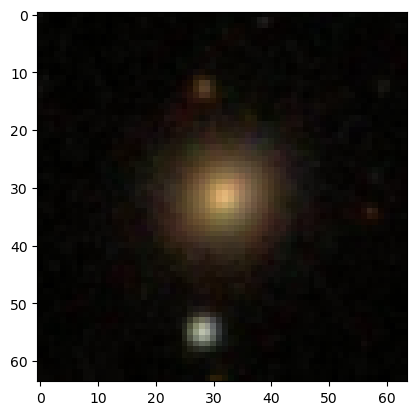

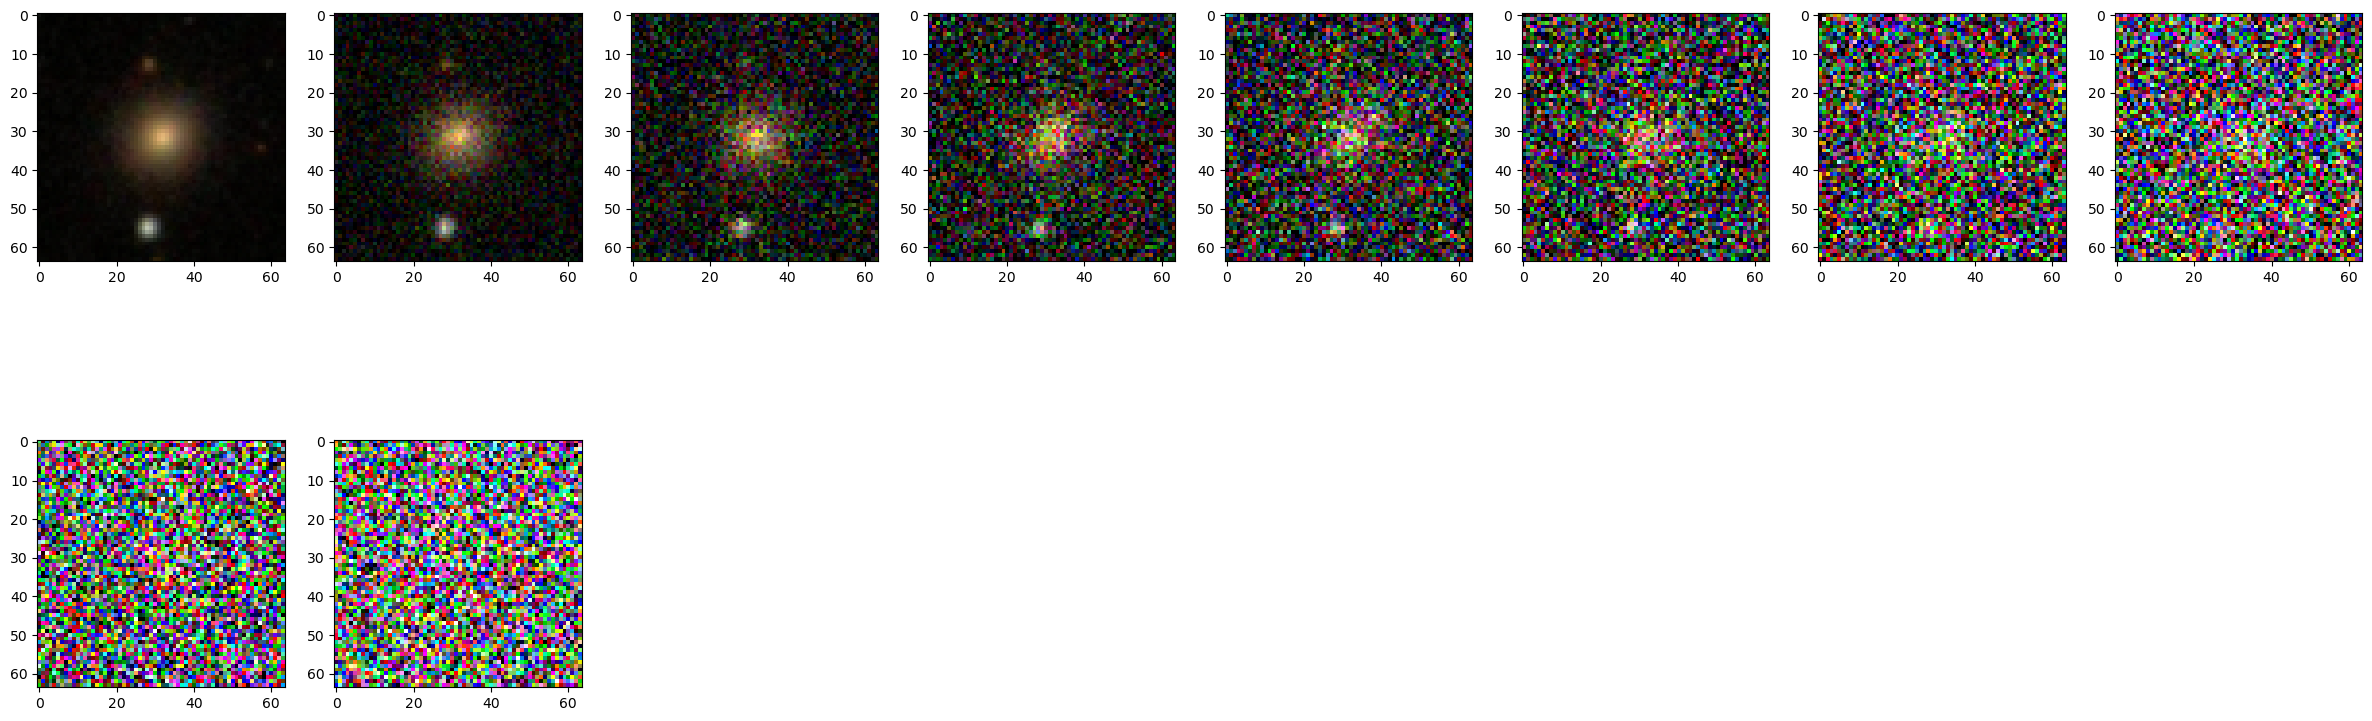

In [5]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.clamp(-1, 1)),
        transforms.Lambda(lambda t: 255 * (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]))

plt.figure(figsize=(30,60))
num_images = 10
stepsize = int(num_timesteps/num_images)

for idx in range(0, num_timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
    plt.imshow(image_from_tensor(tensor[0]), vmin=0, vmax=255)

In [6]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=128,
    num_downsamples=4,
    num_mid_convs=1
    )
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, last_epoch=-1, verbose=False)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  249462787


In [7]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = False
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model, optimizer, lr_scheduler)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=40,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=1,
    log_dir=log_dir+timestamp
    )

  0%|          | 0/7607 [00:00<?, ?it/s]/tmp/torchinductor_md775/4h/c4h55lufyihfdemv5pkrqs4wyoru3xnt2qmpa53wmnpx2abtygzc.py:3965: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  buf0 = extern_kernels.convolution(primals_203, primals_1, stride=(1, 1), padding=(1, 1), dilation=(1, 1), transposed=False, output_padding=(0, 0), groups=1, bias=None)
100%|██████████| 7607/7607 [18:17<00:00,  6.93it/s, Epoch:=1, LR:=0.001, Loss:=0.0913]


Epoch: 1 Loss: 0.0913058932832918
LR: 0.00095


100%|██████████| 7607/7607 [15:58<00:00,  7.93it/s, Epoch:=2, LR:=0.00095, Loss:=0.0752]


Epoch: 2 Loss: 0.07524031610084267
LR: 0.0009025


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=3, LR:=0.000902, Loss:=0.0731]


Epoch: 3 Loss: 0.07306125750479943
LR: 0.000857375


100%|██████████| 7607/7607 [15:08<00:00,  8.38it/s, Epoch:=4, LR:=0.000857, Loss:=0.0714]


Epoch: 4 Loss: 0.07140155059846312
LR: 0.0008145062499999999


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=5, LR:=0.000815, Loss:=0.0713]


Epoch: 5 Loss: 0.07129265472490746
LR: 0.0007737809374999998


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=6, LR:=0.000774, Loss:=0.0705]


Epoch: 6 Loss: 0.07052143866082905
LR: 0.0007350918906249997


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=7, LR:=0.000735, Loss:=0.0701]


Epoch: 7 Loss: 0.0701298892845227
LR: 0.0006983372960937497


100%|██████████| 7607/7607 [15:09<00:00,  8.36it/s, Epoch:=8, LR:=0.000698, Loss:=0.0697]


Epoch: 8 Loss: 0.0697173844771691
LR: 0.0006634204312890621


100%|██████████| 7607/7607 [15:09<00:00,  8.36it/s, Epoch:=9, LR:=0.000663, Loss:=0.07]  


Epoch: 9 Loss: 0.07001872857452512
LR: 0.000630249409724609


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=10, LR:=0.00063, Loss:=0.0696]


Epoch: 10 Loss: 0.06962919087824157
LR: 0.0005987369392383785


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=11, LR:=0.000599, Loss:=0.0691]


Epoch: 11 Loss: 0.0691139267433586
LR: 0.0005688000922764595


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=12, LR:=0.000569, Loss:=0.0694]


Epoch: 12 Loss: 0.06941227332067047
LR: 0.0005403600876626365


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=13, LR:=0.00054, Loss:=0.0686]


Epoch: 13 Loss: 0.0686022845264982
LR: 0.0005133420832795047


100%|██████████| 7607/7607 [15:08<00:00,  8.38it/s, Epoch:=14, LR:=0.000513, Loss:=0.0687]


Epoch: 14 Loss: 0.06868938332396878
LR: 0.00048767497911552944


100%|██████████| 7607/7607 [15:09<00:00,  8.36it/s, Epoch:=15, LR:=0.000488, Loss:=0.0686]


Epoch: 15 Loss: 0.06859140670576123
LR: 0.00046329123015975297


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=16, LR:=0.000463, Loss:=0.0686]


Epoch: 16 Loss: 0.06855707414266086
LR: 0.0004401266686517653


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=17, LR:=0.00044, Loss:=0.0682]


Epoch: 17 Loss: 0.06817778775330613
LR: 0.00041812033521917703


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=18, LR:=0.000418, Loss:=0.0683]


Epoch: 18 Loss: 0.06825484334761396
LR: 0.00039721431845821814


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=19, LR:=0.000397, Loss:=0.0681]


Epoch: 19 Loss: 0.06811268477422368
LR: 0.0003773536025353072


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=20, LR:=0.000377, Loss:=0.0683]


Epoch: 20 Loss: 0.0682515800679946
LR: 0.0003584859224085418


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=21, LR:=0.000358, Loss:=0.0677]


Epoch: 21 Loss: 0.06769369157018691
LR: 0.0003405616262881147


100%|██████████| 7607/7607 [15:10<00:00,  8.35it/s, Epoch:=22, LR:=0.000341, Loss:=0.0679]


Epoch: 22 Loss: 0.06793362646609392
LR: 0.00032353354497370894


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=23, LR:=0.000324, Loss:=0.0678]


Epoch: 23 Loss: 0.06778967568526698
LR: 0.00030735686772502346


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=24, LR:=0.000307, Loss:=0.0679]


Epoch: 24 Loss: 0.06789870014793968
LR: 0.00029198902433877225


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=25, LR:=0.000292, Loss:=0.0674]


Epoch: 25 Loss: 0.06743516453664368
LR: 0.00027738957312183364


100%|██████████| 7607/7607 [15:09<00:00,  8.36it/s, Epoch:=26, LR:=0.000277, Loss:=0.0673]


Epoch: 26 Loss: 0.06725791613634396
LR: 0.0002635200944657419


100%|██████████| 7607/7607 [15:09<00:00,  8.36it/s, Epoch:=27, LR:=0.000264, Loss:=0.0676]


Epoch: 27 Loss: 0.06755687726951232
LR: 0.0002503440897424548


100%|██████████| 7607/7607 [15:09<00:00,  8.36it/s, Epoch:=28, LR:=0.00025, Loss:=0.0676]


Epoch: 28 Loss: 0.06763473516534581
LR: 0.00023782688525533205


100%|██████████| 7607/7607 [15:08<00:00,  8.37it/s, Epoch:=29, LR:=0.000238, Loss:=0.0678]


Epoch: 29 Loss: 0.06780674717086278
LR: 0.00022593554099256544


100%|██████████| 7607/7607 [15:08<00:00,  8.38it/s, Epoch:=30, LR:=0.000226, Loss:=0.0675]


Epoch: 30 Loss: 0.06746720056209542
LR: 0.00021463876394293716


100%|██████████| 7607/7607 [15:07<00:00,  8.38it/s, Epoch:=31, LR:=0.000215, Loss:=0.0673]


Epoch: 31 Loss: 0.06733133338207646
LR: 0.0002039068257457903


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=32, LR:=0.000204, Loss:=0.0675]


Epoch: 32 Loss: 0.06748222713217294
LR: 0.00019371148445850077


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=33, LR:=0.000194, Loss:=0.0671]


Epoch: 33 Loss: 0.06713490543951417
LR: 0.00018402591023557573


100%|██████████| 7607/7607 [15:09<00:00,  8.37it/s, Epoch:=34, LR:=0.000184, Loss:=0.0671]


Epoch: 34 Loss: 0.06711759686370129
LR: 0.00017482461472379692


100%|██████████| 7607/7607 [15:21<00:00,  8.25it/s, Epoch:=35, LR:=0.000175, Loss:=0.0675]


Epoch: 35 Loss: 0.06750346546368513
LR: 0.00016608338398760707


100%|██████████| 7607/7607 [16:47<00:00,  7.55it/s, Epoch:=36, LR:=0.000166, Loss:=0.0672]


Epoch: 36 Loss: 0.0671833557147394
LR: 0.0001577792147882267


100%|██████████| 7607/7607 [16:13<00:00,  7.81it/s, Epoch:=37, LR:=0.000158, Loss:=0.067] 


Epoch: 37 Loss: 0.06700951165973991
LR: 0.00014989025404881537


100%|██████████| 7607/7607 [16:15<00:00,  7.80it/s, Epoch:=38, LR:=0.00015, Loss:=0.0673]


Epoch: 38 Loss: 0.06725719880199556
LR: 0.00014239574134637458


100%|██████████| 7607/7607 [15:59<00:00,  7.93it/s, Epoch:=39, LR:=0.000142, Loss:=0.0669]


Epoch: 39 Loss: 0.06693251203979199
LR: 0.00013527595427905584


100%|██████████| 7607/7607 [16:41<00:00,  7.59it/s, Epoch:=40, LR:=0.000135, Loss:=0.0673]


Epoch: 40 Loss: 0.06728090779799285
LR: 0.00012851215656510304


In [44]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1)[0]

1999it [00:14, 139.62it/s]


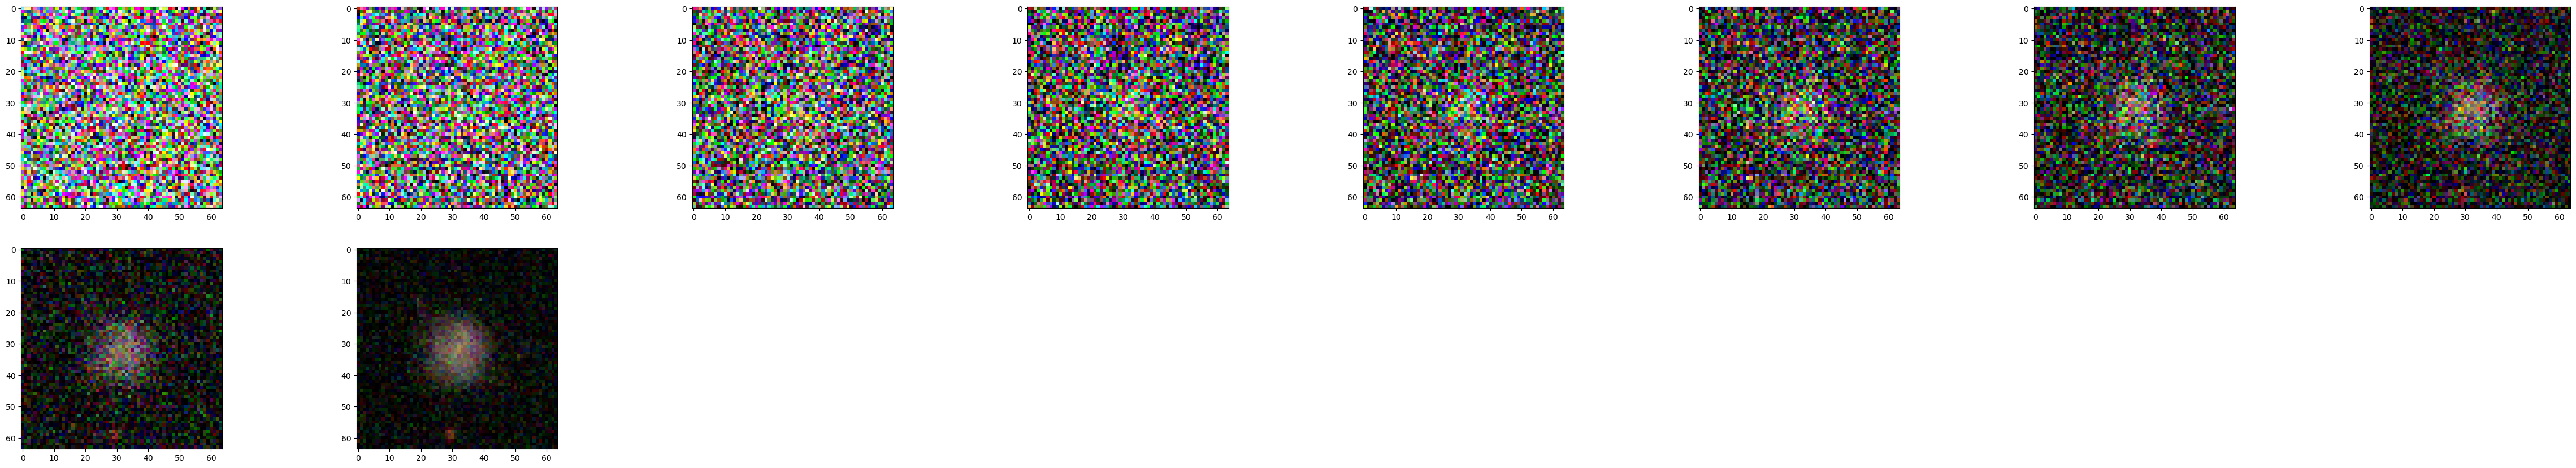

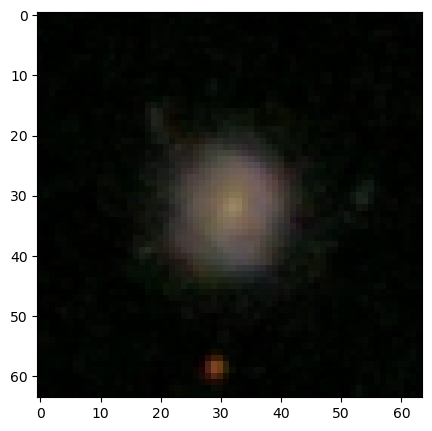

In [45]:
# Visualize reverse process
plt.figure(figsize=(60,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for i, tensor in enumerate(tensor_sample):
    if i % stepsize == 0:
        plt.subplot(int(num_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor))
plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensor_sample[-1]))

In [54]:
# Create gif
from PIL import Image
images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t,tensor in enumerate(tensor_sample):
    if t % stepsize == 0:
        image_array = image_from_tensor(tensor).astype(np.uint8)
        image = Image.fromarray(image_array).convert('RGB')
        images.append(image)
images[0].save(gif_dir + '/galaxies.gif', save_all=True, append_images=images[1:], duration=50)